<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setting" data-toc-modified-id="Setting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setting</a></span><ul class="toc-item"><li><span><a href="#Path" data-toc-modified-id="Path-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Path</a></span></li></ul></li><li><span><a href="#時系列データ作成" data-toc-modified-id="時系列データ作成-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>時系列データ作成</a></span></li><li><span><a href="#Adjust-Input-Shape" data-toc-modified-id="Adjust-Input-Shape-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><code>Adjust</code> Input Shape</a></span></li><li><span><a href="#Load-Model" data-toc-modified-id="Load-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load <code>Model</code></a></span></li><li><span><a href="#Get-Hidden-Layer-Outputs" data-toc-modified-id="Get-Hidden-Layer-Outputs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Get Hidden Layer Outputs</a></span></li><li><span><a href="#get-rid-of-Layer1(Con1D)'s-channels" data-toc-modified-id="get-rid-of-Layer1(Con1D)'s-channels-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>get rid of <code>Layer1(Con1D)</code>'s channels</a></span><ul class="toc-item"><li><span><a href="#get-Layer1(Con1D)-outputs" data-toc-modified-id="get-Layer1(Con1D)-outputs-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>get <code>Layer1(Con1D)</code> outputs</a></span></li><li><span><a href="#get-rid-of-channels" data-toc-modified-id="get-rid-of-channels-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>get rid of channels</a></span></li><li><span><a href="#get-Last-Layer-outputs" data-toc-modified-id="get-Last-Layer-outputs-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>get <code>Last Layer</code> outputs</a></span></li></ul></li><li><span><a href="#Predict" data-toc-modified-id="Predict-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Predict</a></span></li><li><span><a href="#End" data-toc-modified-id="End-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>End</a></span></li></ul></div>

In [87]:
ipynb_title = "try_getLastOutputByChangingHiddenOutput__Conv1d_model__SimpleSinFuncWithNoNoise"
model_filename = "model__create_Conv1d_model__SimpleSinFuncWithNoNoise.h5"

__{{ipynb_title}}.ipynb__

1. データ作成
  - 単なるsin関数を含んだ式
  - ノイズを加える
  - 異常波形作成
1. CNN時系列予測
  - [時系列予測を一次元畳み込みを使って解く with Keras - Qiita
      ](https://qiita.com/niisan-tokyo/items/a94dbd3134219f19cab1)
  - その背景を $windowsize$ 5-60程度で予測するConv1d層の作成

In [37]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path

import keras
print("Keras version : ", keras.__version__)

Keras version :  2.1.6


## Setting

### Path

In [38]:
HOME = Path(os.getcwd()).parent
print(HOME)

/home/pollen/workdir/git/article_script/20180719_visualize_Conv1d_output__in_kabuku


In [39]:
path_list = []
keras_model_h5_Path = HOME / "keras_model_h5"
path_list.append(keras_model_h5_Path)
data_Path = HOME / "data"
path_list.append(data_Path)
plot_images_Path = data_Path / "plot_images"
path_list.append(plot_images_Path)

for _Path in path_list:
    _path = str(_Path)
    if not os.path.exists(_path):
        os.makedirs(name=_path)
        print("make a directory: \n\t", _path)
    else:
        print(os.path.exists(_path), ": ", _path)

True :  /home/pollen/workdir/git/article_script/20180719_visualize_Conv1d_output__in_kabuku/keras_model_h5
True :  /home/pollen/workdir/git/article_script/20180719_visualize_Conv1d_output__in_kabuku/data
True :  /home/pollen/workdir/git/article_script/20180719_visualize_Conv1d_output__in_kabuku/data/plot_images


## 時系列データ作成

$$
\textbf{toyfunc(t)} = \sin\left( \frac{2 \pi}{T} t \right)
$$

In [40]:
def mySin(t, period=100):
    """
    時刻t, 周期period
    """
    return np.sin(2.0 * np.pi * t/period)

In [41]:
# Add Noise
def toy_func(tStart=0, tStop=100, tStep=1, noiseAmpl=0.05):
    """
    T : 
      sin波の周期
    ampl : 
      ノイズ振幅調整
      """
    t = np.arange(start=tStart, stop=tStop, step=tStep)
    noise = np.random.randn(t.shape[0])  # mean=0, standard_deviation=1
    return (t,
            + mySin(t=t, period=100)
            + noiseAmpl * noise )

## `Adjust` Input Shape

In [42]:
tStart = 10000
windowsize = 100
predictsize = 1
wave_size = 300
assert wave_size - windowsize > windowsize  # 後に畳み込むにはこの条件が必要

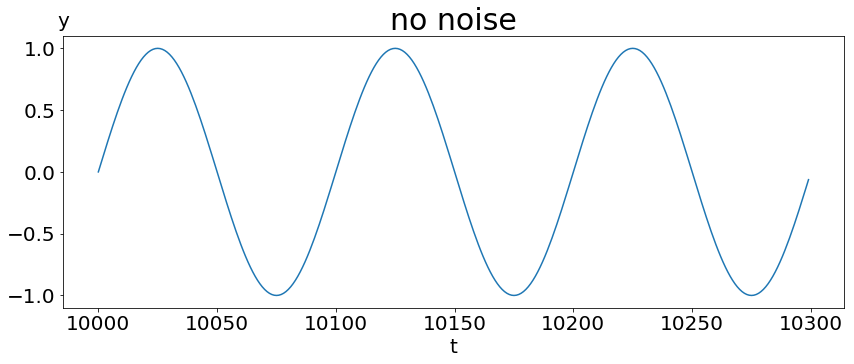

In [43]:
filename = "{}__wave_with_noise.png".format(ipynb_title)

#----------------------------------------
# create a wave
#----------------------------------------
t, wave = toy_func(tStart=tStart, tStop=tStart+wave_size, noiseAmpl=0)

fig = plt.figure(figsize=(14,5))  # (width, height)
ax = fig.add_subplot(1,1,1)
ax.plot(t, wave)

title = "no noise"
ax.set_title(label=title, fontsize=30)
ax.set_xlabel(xlabel="t", fontsize=20)
ax.set_ylabel(ylabel="y", fontsize=20, rotation=0)
ax.yaxis.set_label_coords(x=0.0, y=1.02)
ax.tick_params(labelsize=20)

fig.savefig(fname=str(plot_images_Path / filename))
plt.show()

In [44]:
#----------------------------------------
# create input data
#----------------------------------------
input_arr = np.empty(shape=(0, windowsize))
print(input_arr.shape)
for i in range( wave.shape[0] - (windowsize + predictsize) + 1 ):
    input_arr = np.append(arr=input_arr,
                           values=wave[i:(i+windowsize)].reshape(1, -1),
                           axis=0)
print("input_arr.shape  : ", input_arr.shape)
input_arr = input_arr.reshape((-1, windowsize, 1))
print("input_arr.shape  : ", input_arr.shape)

(0, 100)
input_arr.shape  :  (200, 100)
input_arr.shape  :  (200, 100, 1)


## Load `Model`

In [45]:
from keras.models import load_model

In [46]:
modelpath = str(keras_model_h5_Path / model_filename)
model = load_model(filepath=modelpath)

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 100, 8)            88        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 50, 8)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 50, 8)             648       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 10, 8)             0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 10, 8)             648       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1, 8)              0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 1, 4)              324       
__________

## Get Hidden Layer Outputs

- reference
    - [How can I obtain the output of an intermediate layer? - FAQ - Keras Documentation](
        https://keras.io/getting-started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer)
    - https://stackoverflow.com/questions/41711190/keras-how-to-get-the-output-of-each-layer

In [48]:
from keras.models import Model
from keras import backend as K

In [49]:
inp = model.input

In [50]:
type(model.input)

tensorflow.python.framework.ops.Tensor

In [51]:
outputs = [layer.output for layer in model.layers]
outputs

[<tf.Tensor 'conv1d_6_1/Relu:0' shape=(?, 100, 8) dtype=float32>,
 <tf.Tensor 'max_pooling1d_4_1/Squeeze:0' shape=(?, 50, 8) dtype=float32>,
 <tf.Tensor 'conv1d_7_1/Relu:0' shape=(?, 50, 8) dtype=float32>,
 <tf.Tensor 'max_pooling1d_5_1/Squeeze:0' shape=(?, 10, 8) dtype=float32>,
 <tf.Tensor 'conv1d_8_1/Relu:0' shape=(?, 10, 8) dtype=float32>,
 <tf.Tensor 'max_pooling1d_6_1/Squeeze:0' shape=(?, 1, 8) dtype=float32>,
 <tf.Tensor 'conv1d_9_1/Relu:0' shape=(?, 1, 4) dtype=float32>,
 <tf.Tensor 'conv1d_10_1/Tanh:0' shape=(?, 1, 1) dtype=float32>]

In [52]:
functors = [K.function([inp], [out]) for out in outputs]  # evaluation functions
functors

In [53]:
output_arr = [func([input_arr]) for func in functors]

In [54]:
for i, _arr in enumerate(output_arr):
    print(len(_arr))
    #print(len(output_arr[i]))
    print(_arr[0].shape)

1
(200, 100, 8)
1
(200, 50, 8)
1
(200, 50, 8)
1
(200, 10, 8)
1
(200, 10, 8)
1
(200, 1, 8)
1
(200, 1, 4)
1
(200, 1, 1)


## get rid of `Layer1(Con1D)`'s channels
１層目の出力を自分で作り、２層目以降に入力して出力を取り出したい

- 一層目の出力から特定のチャネルの出力を0にする
- その出力を２層目以降の入力にする

### get `Layer1(Con1D)` outputs

In [58]:
get_layer1_output = K.function(inputs=[model.input],
                               outputs=[model.layers[0].output])
get_layer1_output

In [59]:
layer1_output = get_layer1_output(inputs=[input_arr])[0]

In [61]:
print(layer1_output[0].shape)

1
(200, 100, 8)


(200, 100, 8)


### get rid of channels

In [74]:
layer1_output[:, :, 1] = np.zeros(layer1_output.shape[:2])

In [75]:
shape = layer1_output.shape[:2]
# channel[1,5]を削除
layer1_output[:, :, 1] = np.zeros(shape)
layer1_output[:, :, 5] = np.zeros(shape)
# channel[2,4,7]を削除
layer1_output[:, :, 2] = np.zeros(shape)
layer1_output[:, :, 4] = np.zeros(shape)
layer1_output[:, :, 7] = np.zeros(shape)

### get `Last Layer` outputs

In [77]:
get_last_layer_output = K.function(inputs=[model.layers[1].input],
                                   outputs=[model.output])

In [80]:
last_layer_output = get_last_layer_output(inputs=[layer1_output])[0]

In [81]:
last_layer_output.shape

(200, 1, 1)

## Predict

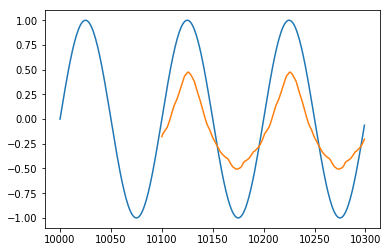

In [86]:
fig = plt.figure(figsize=None)
ax = fig.add_subplot(1,1,1)
ax.plot(t, wave)
ax.plot(t[-len(last_layer_output):], last_layer_output.squeeze())

## End